<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/1DSeparability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook reproduces the 1D example in Christopher Olah's blog on [Neural Networks, Manifolds, and Topology](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/). 

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

plt.style.use('ggplot')

In [87]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(1, 2)
        self.layer2 = nn.Linear(2, 1)

    def forward(self, x1):
        x = torch.sigmoid(self.layer1(x1))
        p = torch.sigmoid(self.layer2(x))[:,0]
        return p

In [91]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

tensor(0.4963)


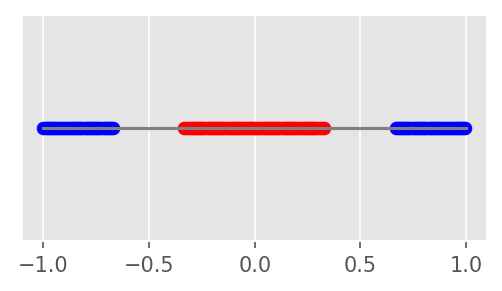

In [92]:
EPOCHS = 100
SEED = 0

np.random.seed(SEED)
torch.manual_seed(SEED)

eps = 1e-16
dx = 0.01

xb = np.concatenate((np.arange(-1,-2/3+eps,dx), np.arange(2/3,1+eps,dx)))
xr = np.arange(-1/3, 1/3+eps, dx)
x = np.concatenate((xb, xr))
x = x.reshape(x.shape[0], 1)

yb = np.zeros(xb.shape[0])
yr = np.ones(xr.shape[0])
y = np.concatenate((yb, yr))

x = Variable(torch.from_numpy(x)).float()
y = Variable(torch.from_numpy(y)).float()

nb = len(yb)

print(y.sum() / y.shape[0])

fig, ax = plt.subplots(figsize=(4,2), dpi=150)
ax.plot([-1,1],[0,0], color='grey')
ax.scatter(xb, [0]*len(xb), color='b')
ax.scatter(xr, [0]*len(xr), color='r')
ax.set_yticks([])
plt.show()

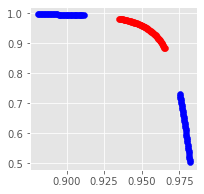

In [93]:
def get_curve(w1, w2, b):
    x1b = 1 / (1 + np.exp(-(w1*xb+b)))
    x1r = 1 / (1 + np.exp(-(w1*xr+b)))
    x2b = 1 / (1 + np.exp(-(w2*xb+b)))
    x2r = 1 / (1 + np.exp(-(w2*xr+b)))
    return x1b, x2b, x1r, x2r

fig, ax = plt.subplots(figsize=(3,3))
x1b, x2b, x1r, x2r = get_curve(1, -3, 3)
ax.scatter(x1b, x2b, color='b')
ax.scatter(x1r, x2r, color='r')
plt.savefig('/content/drive/MyDrive/tmp2.pdf')
plt.show()

In [95]:
# def get_w1_w2_b(x1p, x2p, x1pp, x2pp):
#     k = (x2pp - x2p) / (x1pp - x1p)
#     w2 = 1
#     w1 = -k
#     b = k * x1p - x2p
#     return w1, w2, b
    
# model.layer1.weight.data = torch.tensor([[1.], [-3.]], requires_grad=True)
# model.layer1.bias.data = torch.tensor([3.,3.], requires_grad=True)

# # w1, w2, b = 1, -2.3890, -1.5490
# w1, w2, b = get_w1_w2_b(0.925, 1, 0.975, 0.8)
# model.layer2.weight.data = torch.tensor([[w1, w2]], requires_grad=True)
# model.layer2.bias.data = torch.tensor([b], requires_grad=True)

# fig, ax = plt.subplots(figsize=(3,3))
# x_ = torch.sigmoid(model.layer1(x)).detach().numpy()
# xmin, xmax = x_[:,0].min(), x_[:,0].max()
# x1_ = np.linspace(xmin, xmax, 101)
# x2_ = -(x1_*w1+b) / w2
# ax.scatter(x1_, x2_, color='grey', s=5)
# ax.scatter(*x_[:nb].T, color='b')
# ax.scatter(*x_[nb:].T, color='r')
# plt.show()

In [96]:
# from google.colab import drive
# drive.mount('/content/drive')

In [97]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

get_parameter_count(model)

7

In [98]:
def train_and_validate(model, optimizer, loss_fn, X_train, y_train, X_test, y_test):
    """
    """
    losss = []
    accus = []

    for epoch in tqdm.trange(10000):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            bools = ((y_pred>0.5).long() == y_test).type(torch.FloatTensor)
            accus.append(bools.mean())

    return np.array(losss), np.array(accus)

losss, accus = train_and_validate(model, optimizer, loss_fn, x, y, x, y)


100%|██████████| 10000/10000 [00:07<00:00, 1309.36it/s]


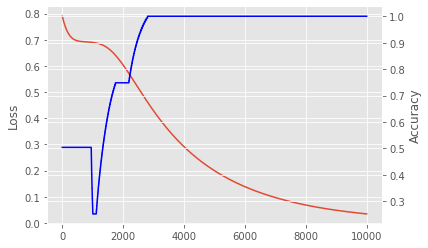

In [99]:
fig, ax = plt.subplots()
ax.plot(losss)
ax.set_ylabel('Loss')
ax2 = ax.twinx()
ax2.plot(accus, color='b')
ax2.set_ylabel('Accuracy')
plt.show()

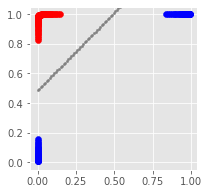

In [110]:
fig, ax = plt.subplots(figsize=(3,3))

x_ = torch.sigmoid(model.layer1(x)).detach().numpy()
xmin, xmax = x_[:,0].min(), x_[:,0].max()

w1, w2 = model.layer2.weight.data.detach().numpy().flatten()
b = model.layer2.bias.data.detach().numpy()[0]

x1_ = np.linspace(xmin, xmax, 101)
x2_ = -(x1_*w1+b) / w2
ax.scatter(x1_, x2_, color='grey', s=5)

ax.scatter(*x_[:nb].T, color='b')
ax.scatter(*x_[nb:].T, color='r')

ax.set_ylim(-0.05, 1.05)

plt.show()